In [1]:
#|default_exp resnet

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch
import numpy as np
import matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

In [3]:
import fastcore.all as fc
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
plt.style.use('fast')

import logging; logging.disable(logging.WARNING)
set_seed(42)

In [4]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
bs = 1024

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
n, avgs, avg_sqrs = 0, [], []
for xb, _ in dls.train:
    n+=1
    avgs.append(xb.mean())
    avg_sqrs.append(xb**2)
    
total_mean = tensor(avgs).mean()
total_std = (torch.concat(avg_sqrs, dim=0).mean() - total_mean**2).sqrt()
total_mean, total_std

(tensor(0.29), tensor(0.35))

In [6]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-total_mean)/total_std for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [7]:
n, avgs, avg_sqrs = 0, [], []
for xb, _ in dls.train:
    n+=1
    avgs.append(xb.mean())
    avg_sqrs.append(xb**2)
    
new_mean = tensor(avgs).mean()
new_std = (torch.concat(avg_sqrs, dim=0).mean() - total_mean**2).sqrt()
new_mean, new_std

(tensor(0.00), tensor(0.96))

In [8]:
#| export
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)

In [9]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [10]:
def get_model(act=GeneralReLU, nfs=(16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=1, act=act, norm=norm), 
              conv(8, 16, stride=1, act=act, norm=norm), ]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(
        *layers, 
        conv(nfs[-1], 10, act=None, norm=norm, bias=True),
        nn.Flatten().to(device))

In [11]:
set_seed(42)
lr, epochs = 6e-2, 10
model = get_model(act_gr).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
extra_cbs = [BatchSchedCB(sched)]
learn = Learner(model, dls, F.cross_entropy, lr=lr, 
                cbs=cbs+extra_cbs)

accuracy,loss,epoch,train
0.675,1.140,0,train
0.804,0.595,0,eval
0.846,0.490,1,train
0.854,0.434,1,eval
0.885,0.350,2,train
0.875,0.364,2,eval
0.902,0.292,3,train
0.880,0.344,3,eval
0.912,0.257,4,train
0.886,0.318,4,eval


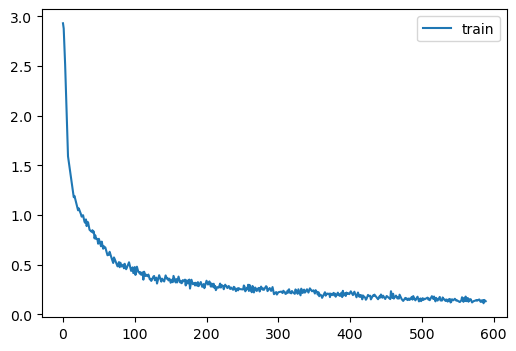

In [12]:
learn.fit(epochs)

# Skip Connections!

In [ ]:
#| export
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                        conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()
    
    def forward(self, x):
        return self.act(self.convs(x) + self.idconv(self.pool(x)))

In [12]:
def get_model(act=GeneralReLU, nfs=(8, 16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(device)

In [13]:
@hook
def _print_shape(hook, mod, inp, out): 
    print(type(mod).__name__, inp[0].shape, out.shape)
    
model = get_model()    
learn = Learner(model, dls, F.cross_entropy, cbs=[DeviceCB(), SingleBatchCB()])

with Hooks(model, shape=_print_shape) as hooks:
    learn.fit(1, train=False)


ResBlock torch.Size([2048, 1, 28, 28]) torch.Size([2048, 8, 28, 28])
ResBlock torch.Size([2048, 8, 28, 28]) torch.Size([2048, 16, 14, 14])
ResBlock torch.Size([2048, 16, 14, 14]) torch.Size([2048, 32, 7, 7])
ResBlock torch.Size([2048, 32, 7, 7]) torch.Size([2048, 64, 4, 4])
ResBlock torch.Size([2048, 64, 4, 4]) torch.Size([2048, 128, 2, 2])
ResBlock torch.Size([2048, 128, 2, 2]) torch.Size([2048, 256, 1, 1])
Flatten torch.Size([2048, 256, 1, 1]) torch.Size([2048, 256])
Linear torch.Size([2048, 256]) torch.Size([2048, 10])
BatchNorm1d torch.Size([2048, 10]) torch.Size([2048, 10])


In [20]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot = 0
    @hook
    def _f(hook,mod, inp, out):
        nonlocal res, tot
        nparams = sum(o.numel() for o in mod.parameters())
        tot += nparams
        res += f'{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(out.shape)}|{nparams}|\n'
    
    with Hooks(self.model, params=_f) as hooks: 
        self.fit(1, train=False, cbs=SingleBatchCB())
    
    print("Total params: ", tot)

    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else:
        print(res)

In [19]:
learn.summary()


Total params:  1228908


|Module|Input|Output|Num params|
|--|--|--|--|
ResBlock|(2048, 1, 28, 28)|(2048, 8, 28, 28)|712|
ResBlock|(2048, 8, 28, 28)|(2048, 16, 14, 14)|3696|
ResBlock|(2048, 16, 14, 14)|(2048, 32, 7, 7)|14560|
ResBlock|(2048, 32, 7, 7)|(2048, 64, 4, 4)|57792|
ResBlock|(2048, 64, 4, 4)|(2048, 128, 2, 2)|230272|
ResBlock|(2048, 128, 2, 2)|(2048, 256, 1, 1)|919296|
Flatten|(2048, 256, 1, 1)|(2048, 256)|0|
Linear|(2048, 256)|(2048, 10)|2560|
BatchNorm1d|(2048, 10)|(2048, 10)|20|


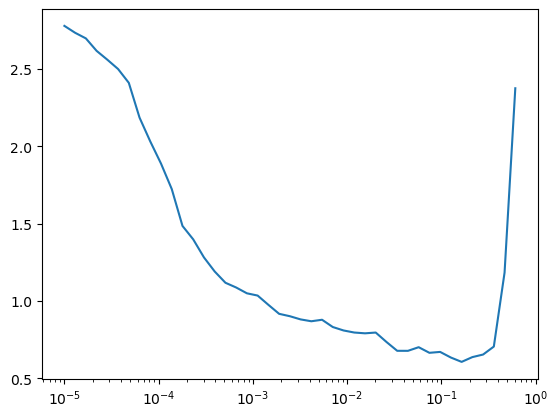

In [25]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
Learner(model, dls, F.cross_entropy, cbs=[DeviceCB(), ProgressCB(plot=True)], opt_func=optim.AdamW).lr_find()

In [28]:
epochs, lr = 5, 1e-1
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
extra_cbs = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+extra_cbs, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.816,0.634,0,train
0.567,1.691,0,eval
0.878,0.344,1,train
0.822,0.486,1,eval
0.908,0.255,2,train
0.898,0.283,2,eval
0.927,0.204,3,train
0.918,0.233,3,eval
0.943,0.159,4,train
0.928,0.204,4,eval


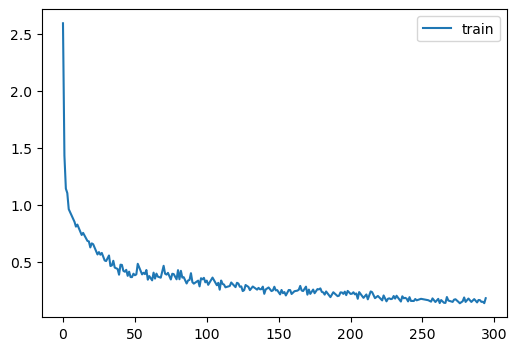

In [29]:
learn.fit(epochs)

# Using Timm

In [34]:
from timm.models.resnet import BasicBlock, Bottleneck, ResNet

In [50]:
model = ResNet(in_chans=1, block=BasicBlock, layers=[2, 2, 2, 2], stem_width=32, avg_down=True)
lr = 5e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
extra_cbs = [BatchSchedCB(sched)]
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+extra_cbs, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.771,0.875,0,train
0.756,0.789,0,eval
0.864,0.369,1,train
0.807,0.623,1,eval
0.894,0.283,2,train
0.887,0.317,2,eval
0.917,0.225,3,train
0.909,0.252,3,eval
0.935,0.176,4,train
0.915,0.237,4,eval


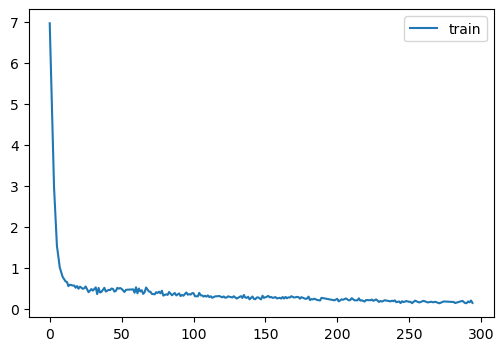

In [51]:
learn.fit(epochs)

In [2]:
import nbdev; nbdev.nbdev_export()